[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2014-01-01 -> 2025-01-22)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


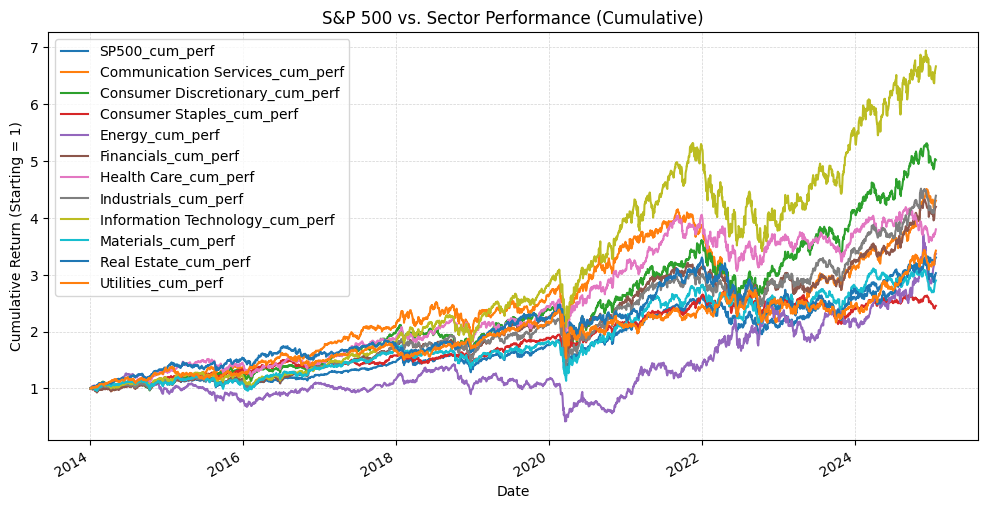

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

class SP500Analysis:
    def __init__(
        self,
        ticker='^GSPC',
        start_date='2014-01-01',
        end_date=None
    ):
        """
        Initialize the analysis object with default parameters.
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date if end_date else datetime.now().strftime('%Y-%m-%d')

        # Columns for cumulative sector performance
        self.sector_cols = [
            "Communication Services",
            "Consumer Discretionary",
            "Consumer Staples",
            "Energy",
            "Financials",
            "Health Care",
            "Industrials",
            "Information Technology",
            "Materials",
            "Real Estate",
            "Utilities"
        ]

        # Data placeholders
        self.sp500_df = None
        self.tickers_df = None
        self.all_tickers_close = None
        self.sector_df = None
        self.merged_df = None

    def calculate_rsi(self, series, period=14):
        """
        Calculate RSI (Relative Strength Index) for a given Series.
        """
        delta = series.diff(1)
        gain = delta.where(delta > 0, 0.0)
        loss = -delta.where(delta < 0, 0.0)

        avg_gain = gain.rolling(window=period).mean()
        avg_loss = loss.rolling(window=period).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def add_bollinger_bands(self, df, window=20, num_std=2):
        """
        Calculate Bollinger Bands for a given DataFrame.
        """
        df['BB_MA'] = df['Close'].rolling(window).mean()
        df['BB_STD'] = df['Close'].rolling(window).std()
        df['BB_Upper'] = df['BB_MA'] + num_std * df['BB_STD']
        df['BB_Lower'] = df['BB_MA'] - num_std * df['BB_STD']
        return df

    def _flatten_columns(self, df):
        """
        If the DataFrame has a MultiIndex for columns, flatten them.
        """
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [
                '_'.join(str(level) for level in col if level)
                for col in df.columns
            ]
        return df

    def download_sp500_data(self):
        """
        Download S&P 500 (^GSPC) data and compute basic technical indicators.
        """
        # Download single-ticker data
        self.sp500_df = yf.download(
            self.ticker,
            start=self.start_date,
            end=self.end_date
        )

        self.sp500_df = self._flatten_columns(self.sp500_df)
        if 'Close' in self.sp500_df.columns:
            self.sp500_df.rename(columns={'Close': 'Close_^GSPC'}, inplace=True)

        # Calculate 50-day and 200-day Moving Averages on the S&P 500 close
        self.sp500_df['50_MA'] = self.sp500_df['Close_^GSPC'].rolling(window=50).mean()
        self.sp500_df['200_MA'] = self.sp500_df['Close_^GSPC'].rolling(window=200).mean()

        # Calculate RSI
        self.sp500_df['RSI'] = self.calculate_rsi(self.sp500_df['Close_^GSPC'], period=14)

        # Calculate Volatility (High - Low)
        if 'High' in self.sp500_df.columns and 'Low' in self.sp500_df.columns:
            self.sp500_df['Volatility'] = self.sp500_df['High'] - self.sp500_df['Low']

        # Bollinger Bands
        self.sp500_df = self.add_bollinger_bands(
            self.sp500_df.rename(columns={'Close_^GSPC': 'Close'}),  # rename temporarily
            window=20,
            num_std=2
        ).rename(columns={'Close': 'Close_^GSPC'})  # rename back

        # Reset index to have 'Date' as a column for merging
        self.sp500_df.reset_index(inplace=True)


    def download_sector_data(self):
        """
        - Scrape the list of S&P 500 companies from Wikipedia
        - Download their Close prices
        - Compute daily average close per sector
        - Compute daily change % for each sector
        - Pivot to wide format
        """
        # Scrape the S&P 500 tickers
        self.tickers_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
        self.tickers_df = self.tickers_df[['Symbol', 'GICS Sector', 'GICS Sub-Industry']]
        self.tickers_df.columns = ['Symbol', 'Sector', 'Industry']
        self.tickers_df.set_index('Symbol', inplace=True)

        # Get list of symbols
        symbols = self.tickers_df.index.to_list()

        # Download close prices for all S&P 500 symbols
        # This returns a DataFrame with columns=[tickers], index=[dates]
        self.all_tickers_close = yf.download(
            symbols,
            start=self.start_date,
            end=self.end_date,
            auto_adjust=True
        )['Close']

        # Flatten columns in case of any multi-level
        self.all_tickers_close = self._flatten_columns(self.all_tickers_close)

        # Reshape data: (Date, Symbol, Close)
        df_500 = self.all_tickers_close.stack().reset_index()
        df_500.columns = ['Date', 'Symbol', 'Close']

        # Merge with sector info
        df_500 = df_500.merge(
            self.tickers_df,
            how='left',
            left_on='Symbol',
            right_index=True
        )

        # Group by (Date, Sector) to get average close
        self.sector_df = (
            df_500
            .groupby(['Date', 'Sector'])['Close']
            .mean()
            .reset_index()
        )

        # Compute daily % change for each sector
        self.sector_df['Daily_Change'] = (
            self.sector_df
            .groupby('Sector')['Close']
            .pct_change()
        )

    def merge_sp500_with_sectors(self):
        """
        Merge the sector daily changes (pivoted) with the S&P 500 dataframe.
        Then compute daily & cumulative returns for the S&P 500 and each sector.
        """
        # Pivot sector_df to get daily change per sector as columns
        pivot_change = self.sector_df.pivot(
            index='Date',
            columns='Sector',
            values='Daily_Change'
        )
        pivot_change = self._flatten_columns(pivot_change)
        self.merged_df = self.sp500_df.copy()
        # self.merged_df has columns including 'Date' as a column

        # Merge pivot_change (index=Date) onto sp500_df (column=Date)
        self.merged_df = self.merged_df.merge(
            pivot_change,
            how='left',
            left_on='Date',
            right_index=True
        )

        self.merged_df['SP500_return'] = self.merged_df['Close_^GSPC'].pct_change()
        self.merged_df['SP500_cum_perf'] = (1 + self.merged_df['SP500_return']).cumprod()
        for sector in self.sector_cols:
            if sector in self.merged_df.columns:
                self.merged_df[f'{sector}_cum_perf'] = (1 + self.merged_df[sector]).cumprod()

        self.merged_df.set_index('Date', inplace=True)

    def plot_performance(self):
        """
        Plot the cumulative performance of the S&P 500 vs. the S&P sectors.
        """
        plot_cols = ['SP500_cum_perf']
        for col in self.sector_cols:
            col_name = f'{col}_cum_perf'
            if col_name in self.merged_df.columns:
                plot_cols.append(col_name)

        self.merged_df[plot_cols].plot(figsize=(12, 6))
        plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
        plt.title("S&P 500 vs. Sector Performance (Cumulative)")
        plt.ylabel("Cumulative Return (Starting = 1)")
        plt.show()

    def run(self):
        """
        Execute the entire workflow in the correct sequence.
        """
        self.download_sp500_data()
        self.download_sector_data()
        self.merge_sp500_with_sectors()
        self.plot_performance()


if __name__ == "__main__":
    analysis = SP500Analysis()
    analysis.run()


In [7]:
df = analysis.merged_df

In [9]:
df = df[df.index >= '2015-01-01']

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2528 entries, 2015-01-02 to 2025-01-21
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Close_^GSPC                      2528 non-null   float64
 1   High_^GSPC                       2528 non-null   float64
 2   Low_^GSPC                        2528 non-null   float64
 3   Open_^GSPC                       2528 non-null   float64
 4   Volume_^GSPC                     2528 non-null   int64  
 5   50_MA                            2528 non-null   float64
 6   200_MA                           2528 non-null   float64
 7   RSI                              2528 non-null   float64
 8   BB_MA                            2528 non-null   float64
 9   BB_STD                           2528 non-null   float64
 10  BB_Upper                         2528 non-null   float64
 11  BB_Lower                         2528 non-null   float64
 12  Co


---

## 1. 50_MA (50-Day Moving Average)

### What It Is
- A moving average is a line showing the average price over a number of days.
- It is a stock indicator commonly used in technical analysis.

### Why It’s Important
- It helps providing a clearer view of the market’s underlying trend.
- The moving average helps to level the price data over a specified period by creating a constantly updated average price.
- A price above the 50-day MA can indicate an uptrend 
- A price below the 50-day MA can indicate a downtrend.

### How It’s Calculated
1. Gather the closing prices for the last 50 trading days.
2. Sum those 50 closing prices.
3. Divide by 50 to get the average.

Mathematically:  
$$
50\_MA = \frac{1}{50} \sum_{i=1}^{50} \text{Close}_{t-i}
$$
Where $$\text{Close}_{t-i}$$ is the closing price $$i$$ days in the past.

---

## 2. 200_MA (200-Day Moving Average)

### What It Is
- Similar to the 50-day MA, but over a longer period (200 days).

### Why It’s Important
- It’s regarded as a measure of the long-term trend.
- To see the overall health of the market.  
- When a price is above the 200-day MA, it’s often considered a **bullish**  below it is considered **bearish**

### How It’s Calculated
- Exactly like the 50-day MA, but using 200 days worth of closing prices.
- The formula:

$$
200\_MA = \frac{1}{200} \sum_{i=1}^{200} \text{Close}_{t-i}
$$

---

## 3. RSI (Relative Strength Index)

### What It Is
- A popular indicattor that measures the speed** and change of price movements.

### Why It’s Important
- RSI is used to identify overbought or oversold signs in the market.
  - a reading above **70** is overbought (price may have risen too far in a short time).
  - A reading below **30** is oversold (price may have fallen too far in a short time).


### How It’s Calculated (14-Day RSI)
1. Calculate daily price changes.
2. Separate those changes into gains and losses .
3. Compute the average gain and average loss over a 14-day period.
4. Compute the relative strength (RS): |
$$
   RS = \frac{\text{Average Gain}}{\text{Average Loss}}
$$
1. Convert **RS** into an index (RSI) on a 0–100 scale: 
$$
   RSI = 100 - \left(\frac{100}{1 + RS}\right)
$$

---

## 4. BB_MA, BB_STD, BB_Upper, BB_Lower (Bollinger Bands)

Bollinger Bands are made up of:

1. **BB_MA (Middle Band)**  
2. **BB_STD (Standard Deviation)**  
3. **BB_Upper (Upper Band)**  
4. **BB_Lower (Lower Band)**  

### What They Are
- A volatility indicator that consists of:
  - A moving average (often 20-day)  
  - Upper and Lower bands plotted at a certain number of standard deviations (often **2**) above and below that average.

### Why They’re Important
- They expand and contract based on volatility:
  - When volatility is high, the bands widen.
  - When volatility is low, the bands narrow.
- Traders watch where the price sits relative to these bands:
  - Price hitting the upper band can suggest the asset may be **overbought** (or trending strongly upward).
  - Price hitting the lower band can suggest the asset may be **oversold** (or trending strongly downward).
- They help identify **potential breakouts** when the price moves outside the bands or the bands “squeeze” (narrow range) before a large move.

### How They’re Calculated
Assume we use a 20-day Bollinger Band with 2 standard deviations:

1. **BB_MA**: 20-day simple moving average of Close.  
$$
   BB\_MA = \frac{1}{20}\sum_{i=1}^{20} \text{Close}_{t-i}
$$
1. **BB_STD**: 20-day standard deviation of Close:
$$
   BB\_STD = \sqrt{\frac{1}{19}\sum_{i=1}^{20} \left(\text{Close}_{t-i} - BB\_MA\right)^2 }
$$
   (Note: exact formula may vary based on sample vs. population standard deviation.)
1. **BB_Upper** = $$ BB\_MA + (2 \times BB\_STD) $$
2. **BB_Lower** = $$ BB\_MA - (2 \times BB\_STD) $$

(Where the multiplier, **2**, is the typical number of standard deviations.)

---



A complete explanation of Bollinger Bands. (z.d.). Bollingerbands. https://www.bollingerbands.com/bollinger-bands

Fernando, J. (2024, 19 november). Relative Strength Index (RSI) Indicator Explained With Formula. Investopedia. https://www.investopedia.com/terms/r/rsi.asp

Fernando, J. (2024a, augustus 6). Moving Average (MA): Purpose, Uses, Formula, and Examples. Investopedia. https://www.investopedia.com/terms/m/movingaverage.asp